<a href="https://colab.research.google.com/github/Dark-Sied/Intent_Classification/blob/master/Intent_classification_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intent Classification using Deep Learning

## 1. Loading Data

In [1]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, GRU, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint

Dataset link: https://raw.githubusercontent.com/PolyAI-LDN/task-specific-datasets/master/banking_data/train.csv

In [2]:
Intent = "category"
Sentence = "text"

In [58]:
def load_dataset(filename, Sentence, Intent):
  df = pd.read_csv(filename, names = [Sentence, Intent])
  intent = df[Intent]
  unique_intent = list(set(intent))
  sentences = list(df[Sentence])
  
  return (df, intent, unique_intent, sentences)

In [59]:
df, intent, unique_intent, sentences = load_dataset("Dataset.csv", "text", "category")

In [5]:
print(df.head(10))

                                                text      category
0                                               text      category
1                     I am still waiting on my card?  card_arrival
2  What can I do if my card still hasn't arrived ...  card_arrival
3  I have been waiting over a week. Is the card s...  card_arrival
4  Can I track my card while it is in the process...  card_arrival
5  How do I know if I will get my card, or if it ...  card_arrival
6                  When did you send me my new card?  card_arrival
7       Do you have info about the card on delivery?  card_arrival
8  What do I do if I still have not received my n...  card_arrival
9       Does the package with my card have tracking?  card_arrival


<AxesSubplot:xlabel='category', ylabel='count'>

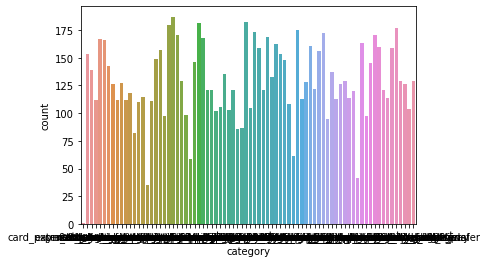

In [63]:
import seaborn as sns
import tkinter
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x=Intent, data=df)

In [7]:
print(sentences[:5])

['text', 'I am still waiting on my card?', "What can I do if my card still hasn't arrived after 2 weeks?", 'I have been waiting over a week. Is the card still coming?', 'Can I track my card while it is in the process of delivery?']


In [8]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shiningflash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/shiningflash/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## 2. Data Cleaning

In [9]:
#define stemmer
stemmer = LancasterStemmer()

In [10]:
def cleaning(sentences):
  words = []
  for s in sentences:
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
    w = word_tokenize(clean)
    words.append([i.lower() for i in w])
    
  return words 

In [11]:
cleaned_words = cleaning(sentences)
print(len(cleaned_words))
print(cleaned_words[:2])  

10004
[['text'], ['i', 'am', 'still', 'waiting', 'on', 'my', 'card']]


## 3. Texts Tokenization

In [12]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
  token = Tokenizer(filters = filters)
  token.fit_on_texts(words)
  return token

In [13]:
def max_length(words):
  return(len(max(words, key = len)))

In [14]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 2343 and Maximum length = 84


In [15]:
def encoding_doc(token, words):
  return(token.texts_to_sequences(words))

In [16]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

In [17]:
def padding_doc(encoded_doc, max_length):
  return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [18]:
padded_doc = padding_doc(encoded_doc, max_length)

In [20]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (10004, 84)


In [21]:
#tokenizer with filter changed
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')

In [22]:
output_tokenizer.word_index

{'exchange_rate': 1,
 'contactless_not_working': 2,
 'declined_cash_withdrawal': 3,
 'card_arrival': 4,
 'card_payment_fee_charged': 5,
 'wrong_exchange_rate_for_cash_withdrawal': 6,
 'why_verify_identity': 7,
 'passcode_forgotten': 8,
 'cash_withdrawal_charge': 9,
 'top_up_limits': 10,
 'balance_not_updated_after_cheque_or_cash_deposit': 11,
 'transfer_timing': 12,
 'balance_not_updated_after_bank_transfer': 13,
 'card_payment_not_recognised': 14,
 'failed_transfer': 15,
 'transaction_charged_twice': 16,
 'order_physical_card': 17,
 'wrong_amount_of_cash_received': 18,
 'card_not_working': 19,
 'pending_transfer': 20,
 'direct_debit_payment_not_recognised': 21,
 'getting_virtual_card': 22,
 'edit_personal_details': 23,
 'compromised_card': 24,
 'transfer_fee_charged': 25,
 'verify_my_identity': 26,
 'country_support': 27,
 'top_up_by_card_charge': 28,
 'refund_not_showing_up': 29,
 'cancel_transfer': 30,
 'get_physical_card': 31,
 'receiving_money': 32,
 'card_swallowed': 33,
 'age_li

In [23]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [24]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [25]:
encoded_output.shape

(10004, 1)

In [26]:
def one_hot(encode):
  o = OneHotEncoder(sparse = False)
  return(o.fit_transform(encode))

In [27]:
output_one_hot = one_hot(encoded_output)

In [28]:
output_one_hot.shape

(10004, 78)

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)

In [31]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (8003, 84) and train_Y = (8003, 78)
Shape of val_X = (2001, 84) and val_Y = (2001, 78)


## 4. Bidirectional GRU 

In [32]:
def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(GRU(128)))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(78, activation = "softmax"))
  
  return model

In [33]:
model = create_model(vocab_size, max_length)

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 84, 128)           299904    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               198144    
_________________________________________________________________
dense (Dense)                (None, 32)                8224      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 78)                2574      
Total params: 508,846
Trainable params: 208,942
Non-trainable params: 299,904
_________________________________________________________________


In [34]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

In [35]:
hist = model.fit(train_X, train_Y,
                 epochs = 100,
                 batch_size = 32,
                 validation_data = (val_X, val_Y),
                 callbacks = [checkpoint])

Epoch 1/100
250/251 [============================>.] - ETA: 0s - loss: 4.3465 - accuracy: 0.0151
Epoch 00001: val_loss improved from inf to 4.32916, saving model to model.h5
251/251 [==============================] - 19s 76ms/step - loss: 4.3465 - accuracy: 0.0151 - val_loss: 4.3292 - val_accuracy: 0.0165
Epoch 2/100
250/251 [============================>.] - ETA: 0s - loss: 4.2141 - accuracy: 0.0278
Epoch 00002: val_loss improved from 4.32916 to 3.97493, saving model to model.h5
251/251 [==============================] - 20s 80ms/step - loss: 4.2141 - accuracy: 0.0277 - val_loss: 3.9749 - val_accuracy: 0.0360
Epoch 3/100
250/251 [============================>.] - ETA: 0s - loss: 3.8663 - accuracy: 0.0469
Epoch 00003: val_loss improved from 3.97493 to 3.69397, saving model to model.h5
251/251 [==============================] - 21s 82ms/step - loss: 3.8663 - accuracy: 0.0469 - val_loss: 3.6940 - val_accuracy: 0.0925
Epoch 4/100
250/251 [============================>.] - ETA: 0s - loss: 

Epoch 28/100
250/251 [============================>.] - ETA: 0s - loss: 1.6912 - accuracy: 0.4611
Epoch 00028: val_loss improved from 1.53701 to 1.50611, saving model to model.h5
251/251 [==============================] - 21s 82ms/step - loss: 1.6908 - accuracy: 0.4612 - val_loss: 1.5061 - val_accuracy: 0.5587
Epoch 29/100
251/251 [==============================] - ETA: 0s - loss: 1.6325 - accuracy: 0.4681
Epoch 00029: val_loss improved from 1.50611 to 1.49190, saving model to model.h5
251/251 [==============================] - 22s 87ms/step - loss: 1.6325 - accuracy: 0.4681 - val_loss: 1.4919 - val_accuracy: 0.5662
Epoch 30/100
251/251 [==============================] - ETA: 0s - loss: 1.6268 - accuracy: 0.4768
Epoch 00030: val_loss improved from 1.49190 to 1.47826, saving model to model.h5
251/251 [==============================] - 25s 98ms/step - loss: 1.6268 - accuracy: 0.4768 - val_loss: 1.4783 - val_accuracy: 0.5707
Epoch 31/100
250/251 [============================>.] - ETA: 0s 

250/251 [============================>.] - ETA: 0s - loss: 1.0022 - accuracy: 0.6619
Epoch 00055: val_loss did not improve from 1.32746
251/251 [==============================] - 19s 77ms/step - loss: 1.0026 - accuracy: 0.6618 - val_loss: 1.4188 - val_accuracy: 0.6622
Epoch 56/100
250/251 [============================>.] - ETA: 0s - loss: 0.9672 - accuracy: 0.6740
Epoch 00056: val_loss did not improve from 1.32746
251/251 [==============================] - 22s 87ms/step - loss: 0.9670 - accuracy: 0.6741 - val_loss: 1.4549 - val_accuracy: 0.6647
Epoch 57/100
250/251 [============================>.] - ETA: 0s - loss: 0.9549 - accuracy: 0.6837
Epoch 00057: val_loss did not improve from 1.32746
251/251 [==============================] - 19s 75ms/step - loss: 0.9546 - accuracy: 0.6839 - val_loss: 1.4007 - val_accuracy: 0.6667
Epoch 58/100
250/251 [============================>.] - ETA: 0s - loss: 0.9149 - accuracy: 0.6886
Epoch 00058: val_loss did not improve from 1.32746
251/251 [=========

251/251 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.7806
Epoch 00084: val_loss did not improve from 1.32746
251/251 [==============================] - 28s 113ms/step - loss: 0.6376 - accuracy: 0.7806 - val_loss: 1.7580 - val_accuracy: 0.6887
Epoch 85/100
250/251 [============================>.] - ETA: 0s - loss: 0.6081 - accuracy: 0.7836
Epoch 00085: val_loss did not improve from 1.32746
251/251 [==============================] - 20s 79ms/step - loss: 0.6084 - accuracy: 0.7835 - val_loss: 1.7240 - val_accuracy: 0.7096
Epoch 86/100
250/251 [============================>.] - ETA: 0s - loss: 0.6152 - accuracy: 0.7806
Epoch 00086: val_loss did not improve from 1.32746
251/251 [==============================] - 18s 72ms/step - loss: 0.6150 - accuracy: 0.7807 - val_loss: 1.9603 - val_accuracy: 0.6827
Epoch 87/100
250/251 [============================>.] - ETA: 0s - loss: 0.6544 - accuracy: 0.7774
Epoch 00087: val_loss did not improve from 1.32746
251/251 [========

## 5. Bidirectional LSTM 

In [36]:
def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
  model.add(Bidirectional(LSTM(128)))
  model.add(Dense(32, activation = "relu"))
  model.add(Dropout(0.5))
  model.add(Dense(78, activation = "softmax"))
  
  return model

model_lstm = create_model(vocab_size, max_length)

model_lstm.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 84, 128)           299904    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 78)                2574      
Total params: 573,870
Trainable params: 273,966
Non-trainable params: 299,904
_________________________________________________________________


In [37]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

hist = model_lstm.fit(train_X, train_Y,
                 epochs = 100,
                 batch_size = 32,
                 validation_data = (val_X, val_Y),
                 callbacks = [checkpoint])

Epoch 1/100
250/251 [============================>.] - ETA: 0s - loss: 4.3283 - accuracy: 0.0184
Epoch 00001: val_loss improved from inf to 4.23865, saving model to model.h5
251/251 [==============================] - 23s 92ms/step - loss: 4.3278 - accuracy: 0.0184 - val_loss: 4.2386 - val_accuracy: 0.0150
Epoch 2/100
250/251 [============================>.] - ETA: 0s - loss: 4.1311 - accuracy: 0.0318
Epoch 00002: val_loss improved from 4.23865 to 3.97603, saving model to model.h5
251/251 [==============================] - 23s 90ms/step - loss: 4.1311 - accuracy: 0.0317 - val_loss: 3.9760 - val_accuracy: 0.0500
Epoch 3/100
250/251 [============================>.] - ETA: 0s - loss: 3.8447 - accuracy: 0.0582
Epoch 00003: val_loss improved from 3.97603 to 3.59888, saving model to model.h5
251/251 [==============================] - 23s 90ms/step - loss: 3.8447 - accuracy: 0.0582 - val_loss: 3.5989 - val_accuracy: 0.0815
Epoch 4/100
250/251 [============================>.] - ETA: 0s - loss: 

Epoch 28/100
250/251 [============================>.] - ETA: 0s - loss: 1.7536 - accuracy: 0.4535
Epoch 00028: val_loss did not improve from 1.67843
251/251 [==============================] - 28s 110ms/step - loss: 1.7535 - accuracy: 0.4536 - val_loss: 1.7034 - val_accuracy: 0.4988
Epoch 29/100
250/251 [============================>.] - ETA: 0s - loss: 1.7234 - accuracy: 0.4550
Epoch 00029: val_loss did not improve from 1.67843
251/251 [==============================] - 22s 89ms/step - loss: 1.7238 - accuracy: 0.4550 - val_loss: 1.7211 - val_accuracy: 0.5042
Epoch 30/100
250/251 [============================>.] - ETA: 0s - loss: 1.8046 - accuracy: 0.4397
Epoch 00030: val_loss improved from 1.67843 to 1.65198, saving model to model.h5
251/251 [==============================] - 22s 89ms/step - loss: 1.8046 - accuracy: 0.4397 - val_loss: 1.6520 - val_accuracy: 0.5092
Epoch 31/100
251/251 [==============================] - ETA: 0s - loss: 1.6849 - accuracy: 0.4712
Epoch 00031: val_loss imp

250/251 [============================>.] - ETA: 0s - loss: 1.1245 - accuracy: 0.6335
Epoch 00056: val_loss did not improve from 1.47035
251/251 [==============================] - 25s 98ms/step - loss: 1.1247 - accuracy: 0.6335 - val_loss: 1.5550 - val_accuracy: 0.6067
Epoch 57/100
250/251 [============================>.] - ETA: 0s - loss: 1.1541 - accuracy: 0.6230
Epoch 00057: val_loss did not improve from 1.47035
251/251 [==============================] - 23s 93ms/step - loss: 1.1542 - accuracy: 0.6229 - val_loss: 1.5658 - val_accuracy: 0.6247
Epoch 58/100
250/251 [============================>.] - ETA: 0s - loss: 1.1561 - accuracy: 0.6220
Epoch 00058: val_loss did not improve from 1.47035
251/251 [==============================] - 23s 91ms/step - loss: 1.1562 - accuracy: 0.6219 - val_loss: 1.5224 - val_accuracy: 0.6062
Epoch 59/100
251/251 [==============================] - ETA: 0s - loss: 1.1351 - accuracy: 0.6343
Epoch 00059: val_loss did not improve from 1.47035
251/251 [=========

250/251 [============================>.] - ETA: 0s - loss: 0.7700 - accuracy: 0.7398
Epoch 00085: val_loss did not improve from 1.47035
251/251 [==============================] - 26s 102ms/step - loss: 0.7698 - accuracy: 0.7398 - val_loss: 1.7245 - val_accuracy: 0.6712
Epoch 86/100
250/251 [============================>.] - ETA: 0s - loss: 0.7938 - accuracy: 0.7293
Epoch 00086: val_loss did not improve from 1.47035
251/251 [==============================] - 26s 102ms/step - loss: 0.7939 - accuracy: 0.7291 - val_loss: 1.6741 - val_accuracy: 0.6632
Epoch 87/100
250/251 [============================>.] - ETA: 0s - loss: 0.8106 - accuracy: 0.7311
Epoch 00087: val_loss did not improve from 1.47035
251/251 [==============================] - 26s 103ms/step - loss: 0.8104 - accuracy: 0.7312 - val_loss: 1.6221 - val_accuracy: 0.6597
Epoch 88/100
250/251 [============================>.] - ETA: 0s - loss: 0.7570 - accuracy: 0.7386
Epoch 00088: val_loss did not improve from 1.47035
251/251 [======

In [38]:
model_lstm = load_model("model.h5")

In [46]:
def predictions(text):
  clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
  test_word = word_tokenize(clean)
  test_word = [w.lower() for w in test_word]
  test_ls = word_tokenizer.texts_to_sequences(test_word)
#   print(test_ls)
#   print(test_word)

  #Check for unknown words
  if [] in test_ls:
    test_ls = list(filter(None, test_ls))
    
  test_ls = np.array(test_ls).reshape(1, len(test_ls))
  x = padding_doc(test_ls, max_length)
    
#   print(x)

  pred = model_lstm.predict(x)
  
  return pred

In [53]:
def get_final_output(pred, classes):
  predictions = pred[0]
#   print(predictions)
  classes = np.array(classes)
#   print(classes)
  ids = np.argsort(-predictions)
  classes = classes[ids]
#   print(classes)
  predictions = -np.sort(-predictions)
 
  for i in range(pred.shape[1]):
    print("%s has confidence = %s" % (classes[i], (predictions[i])))
  
  return classes[0]

In [54]:
text = "I am still waiting on my card?"
pred = predictions(text)
result = get_final_output(pred, unique_intent)
print('\nans: {}\n'.format(result))

card_arrival has confidence = 0.388203
card_not_working has confidence = 0.2828172
card_delivery_estimate has confidence = 0.10544735
card_swallowed has confidence = 0.05497793
declined_card_payment has confidence = 0.044158656
activate_my_card has confidence = 0.03831381
lost_or_stolen_card has confidence = 0.0148200765
card_payment_fee_charged has confidence = 0.013619259
compromised_card has confidence = 0.010870798
card_acceptance has confidence = 0.010216601
contactless_not_working has confidence = 0.009105929
transaction_charged_twice has confidence = 0.007043392
declined_cash_withdrawal has confidence = 0.004485206
reverted_card_payment? has confidence = 0.004468125
card_about_to_expire has confidence = 0.0038785327
atm_support has confidence = 0.0020097475
cash_withdrawal_not_recognised has confidence = 0.0011436713
pin_blocked has confidence = 0.00084258296
card_linking has confidence = 0.0007778044
pending_card_payment has confidence = 0.00037651244
lost_or_stolen_phone has c

In [55]:
text = "What are you exchange rates?"
pred = predictions(text)
result = get_final_output(pred, unique_intent)
print('\nans: {}\n'.format(result))

exchange_rate has confidence = 0.99568826
fiat_currency_support has confidence = 0.0020600427
card_payment_wrong_exchange_rate has confidence = 0.0007059075
exchange_charge has confidence = 0.00044949
exchange_via_app has confidence = 0.00043904345
supported_cards_and_currencies has confidence = 0.00037469165
automatic_top_up has confidence = 0.00014319515
wrong_exchange_rate_for_cash_withdrawal has confidence = 6.349546e-05
verify_source_of_funds has confidence = 3.964243e-05
top_up_by_bank_transfer_charge has confidence = 2.3390774e-05
receiving_money has confidence = 9.816018e-06
top_up_by_cash_or_cheque has confidence = 2.6036785e-06
transfer_into_account has confidence = 3.3181928e-07
wrong_amount_of_cash_received has confidence = 1.0008942e-07
country_support has confidence = 3.2529005e-08
atm_support has confidence = 2.884979e-08
age_limit has confidence = 7.880087e-09
visa_or_mastercard has confidence = 7.676242e-09
edit_personal_details has confidence = 4.454245e-11
why_verify

In [56]:
text = "Which countries are represented?"
pred = predictions(text)
result = get_final_output(pred, unique_intent)
print('\nans: {}\n'.format(result))

country_support has confidence = 0.6209605
getting_spare_card has confidence = 0.19558908
visa_or_mastercard has confidence = 0.09848333
order_physical_card has confidence = 0.03703459
supported_cards_and_currencies has confidence = 0.014996924
card_acceptance has confidence = 0.011216355
atm_support has confidence = 0.007959759
card_about_to_expire has confidence = 0.0064256815
card_delivery_estimate has confidence = 0.0020956346
verify_source_of_funds has confidence = 0.0013296802
receiving_money has confidence = 0.0008137022
disposable_card_limits has confidence = 0.0006901232
lost_or_stolen_card has confidence = 0.00059694407
top_up_by_card_charge has confidence = 0.00038836425
card_payment_fee_charged has confidence = 0.00034286594
card_linking has confidence = 0.00018339833
age_limit has confidence = 0.00014364916
card_not_working has confidence = 0.0001402933
compromised_card has confidence = 0.00012902418
get_disposable_virtual_card has confidence = 0.00012286741
activate_my_ca